# Challenge Optimisation 2020

** Donnés d'entrée ** : 
- N: Nombre de spins
- K: Niveau maximal d'interaction considéré

** Sortie ** : Une séquence (s0, ...., sN-1) avec sK dans {-1, 1}

** Score (à optimiser) ** : 

![](../img/score.PNG)

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import leastsq
from numba import jit

### Importation des données d'entrée

In [2]:
df_instances = pd.read_csv('../data/instances.txt', delim_whitespace=True, index_col=False)

In [3]:
df_instances.head()

,N,K
0,10,2
1,10,4
2,10,6
3,10,8
4,10,10


### Heuristique proposée, algorithme de descente naif

In [4]:
@jit(nopython=True)
def getRandomSolution(size):
    return np.random.choice(np.array([-1, 1]), size)

getRandomSolution(5)

array([ 1,  1, -1,  1,  1], dtype=int64)

In [5]:
@jit(nopython=True)
def computeScore(solution, K) -> int:
    N = len(solution)
    score = 0
    for i in range(1, K):
        inter_score = 0
        for j in range(0, N-i):
            inter_score += solution[j] * solution[j+i]
        score += inter_score ** 2.0

    return score

print(f'Score of [1, 1, -1, 1, 1] = {computeScore([1, 1, -1, 1, 1], 2)}')
print(f'Score of [-1, 1, 1, 1, 1, -1, 1, 1, 1, -1] = {computeScore([-1, 1, 1, 1, 1, -1, 1, 1, 1, -1], 5)}')

Score of [1, 1, -1, 1, 1] = 0.0
Score of [-1, 1, 1, 1, 1, -1, 1, 1, 1, -1] = 6.0


In [6]:
@jit(nopython=True)
def heuristic(size: int, K: int):

    solution = getRandomSolution(size)
    best = computeScore(solution, K)
    i = 0
    fail = 0

    while fail < size:
        
        # print(f"iteration {i} : fails={fail}")

        solution[i] = -solution[i]
        new_score = computeScore(solution, K)

        if new_score < best:
            # print(f"New Best Score ! {new_score}")
            best = new_score
            fail = 0
        else:
            solution[i] = -solution[i]
            fail += 1
        
        i += 1
        if i == size:
            i = 0
        
    return solution, best

In [7]:
heuristic(10, 5)

(array([-1, -1, -1,  1,  1, -1,  1, -1,  1,  1], dtype=int64), 6.0)

In [8]:
@jit(nopython=True)
def heuristic_iter(size: int, K: int, n_iters=100):
    solution = None
    score = np.inf

    for i in range(n_iters):

        _solution, _score = heuristic(size, K)
        
        # print(f'Iteration n°{i} : score = {_score}')

        if _score < score :
            solution = _solution
            score = _score
    
    return solution, score

In [9]:
solution, score = heuristic_iter(10, 5)
print(f"Found solution : {solution} with score={score}")

Found solution : [ 1  1 -1 -1  1 -1  1 -1 -1 -1] with score=2.0


### Résolution des instances et exportation des résultats

In [10]:
df_instances.values

array([[  10,    2],
       [  10,    4],
       [  10,    6],
       [  10,    8],
       [  10,   10],
       [  20,    4],
       [  20,    8],
       [  20,   12],
       [  20,   16],
       [  20,   20],
       [  50,   10],
       [  50,   20],
       [  50,   30],
       [  50,   40],
       [  50,   50],
       [  75,    5],
       [  75,   10],
       [  75,   25],
       [  75,   50],
       [  75,   75],
       [ 100,    2],
       [ 100,    5],
       [ 100,   10],
       [ 100,   50],
       [ 100,  100],
       [ 200,    2],
       [ 200,    5],
       [ 200,   10],
       [ 200,   50],
       [ 200,  100],
       [ 500,    5],
       [ 500,   10],
       [ 500,   50],
       [ 500,  100],
       [ 500,  200],
       [1000,   10],
       [1000,   25],
       [1000,   50],
       [1000,  100],
       [1000,  250],
       [2000,   10],
       [2000,   25],
       [2000,   50],
       [2000,  100],
       [2000,  250],
       [5000,   10],
       [5000,   50],
       [5000,

In [11]:
def exportSolutions(instances, n_iters=100):
    for instance in instances[39:]:
        print(f'Exporting {instance}...')
        N, K = instance
        _solution, _score = heuristic_iter(N, K, n_iters=n_iters)

        headers = [N, K] + [''] * (N-2)

        pd.DataFrame(_solution.reshape(-1, len(_solution))).to_csv(f"../solutions/res_{N}_{K}.csv", index=False, header=headers)

In [ ]:
exportSolutions(df_instances.values)

### Genetic algorithm

In [15]:
def cal_pop_fitness(K, pop):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function caulcuates the sum of products between each input and its corresponding weight.
    fitness = np.apply_along_axis(computeScore, 1, pop, K)
    return fitness

def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        min_fitness_idx = np.where(fitness == np.min(fitness))
        min_fitness_idx = min_fitness_idx[0][0]
        parents[parent_num, :] = pop[min_fitness_idx, :]
        fitness[min_fitness_idx] = 999999999
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually it is at the center.
    crossover_point = np.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, num_mutations=1):
    mutations_counter = np.uint8(offspring_crossover.shape[1] / num_mutations)
    # Mutation changes a number of genes as defined by the num_mutations argument. The changes are random.
    for idx in range(offspring_crossover.shape[0]):
        gene_idx = mutations_counter - 1
        for mutation_num in range(num_mutations):
            # The random value to be added to the gene.
            random_value = np.random.choice([-1, 1])
            offspring_crossover[idx, gene_idx] = random_value
            gene_idx = gene_idx + mutations_counter
    return offspring_crossover

In [16]:
"""
The y=target is to minimize this equation ASAP:
    y = computeScore(x0....xN-1, k) where k = (1, ..., K-1)
    What are the best values for the N weights x0 to xN-1?
    We are going to use the genetic algorithm for the best possible values after a number of generations.
"""

N = 10
K = 5

# Inputs of the equation.
equation_inputs = K

# Number of the weights we are looking to optimize.
num_weights = N

"""
Genetic algorithm parameters:
    Mating pool size
    Population size
"""
sol_per_pop = 8
num_parents_mating = N // 2

# Defining the population size.
pop_size = (sol_per_pop,num_weights) # The population will have sol_per_pop chromosome where each chromosome has num_weights genes.
#Creating the initial population.
new_population = np.random.choice([-1, 1], size=pop_size)
print(new_population)

best_outputs = []
num_generations = 1000
for generation in range(num_generations):
    # print("Generation : ", generation)
    # Measing the fitness of each chromosome in the population.
    fitness = cal_pop_fitness(K, new_population)

    best_outputs.append(np.min(np.apply_along_axis(computeScore, 1, new_population, K)))

    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, fitness, 
                                      num_parents_mating)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents,
                                       offspring_size=(pop_size[0]-parents.shape[0], num_weights))

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover, num_mutations=2)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

    # The best result in the current iteration.
    # print("Best result : ", np.min(np.apply_along_axis(computeScore, 1, new_population, K)))

# Getting the best solution after iterating finishing all generations.
#At first, the fitness is calculated for each solution in the final generation.
fitness = cal_pop_fitness(equation_inputs, new_population)
# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.min(fitness))

# print(new_population)

print("Best solution : ", new_population[best_match_idx, :][0][0])
print("Best solution fitness : ", fitness[best_match_idx])

[[ 1 -1  1  1 -1  1 -1 -1  1 -1]
 [ 1  1 -1  1  1  1 -1 -1 -1 -1]
 [ 1  1  1  1 -1  1 -1 -1 -1  1]
 [ 1  1  1 -1  1  1  1  1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1  1 -1  1]
 [-1 -1 -1 -1 -1 -1  1  1  1  1]
 [-1  1  1 -1 -1 -1  1  1  1  1]
 [-1  1 -1  1  1  1  1 -1 -1  1]]
Best solution :  [ 1  1  1  1 -1  1 -1 -1 -1  1]
Best solution fitness :  [6. 6.]


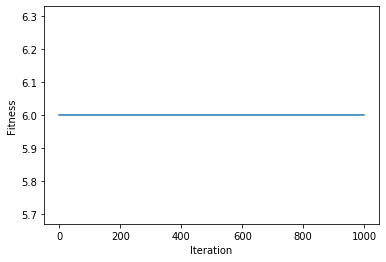

In [17]:
import matplotlib.pyplot
matplotlib.pyplot.plot(best_outputs)
matplotlib.pyplot.xlabel("Iteration")
matplotlib.pyplot.ylabel("Fitness")
matplotlib.pyplot.show()

In [18]:
def genetic_algorithm(N, K):
    """
    The y=target is to minimize this equation ASAP:
        y = computeScore(x0....xN-1, k) where k = (1, ..., K-1)
        What are the best values for the N weights x0 to xN-1?
        We are going to use the genetic algorithm for the best possible values after a number of generations.
    """

    # Inputs of the equation.
    equation_inputs = K

    # Number of the weights we are looking to optimize.
    num_weights = N

    """
    Genetic algorithm parameters:
        Mating pool size
        Population size
    """
    sol_per_pop = 8
    num_parents_mating = N // 2

    # Defining the population size.
    pop_size = (sol_per_pop,num_weights) # The population will have sol_per_pop chromosome where each chromosome has num_weights genes.
    #Creating the initial population.
    new_population = np.random.choice([-1, 1], size=pop_size)
    print(new_population)

    best_outputs = []
    num_generations = 1000
    for generation in range(num_generations):
        # print("Generation : ", generation)
        # Measing the fitness of each chromosome in the population.
        fitness = cal_pop_fitness(K, new_population)

        best_outputs.append(np.min(np.apply_along_axis(computeScore, 1, new_population, K)))

        # Selecting the best parents in the population for mating.
        parents = select_mating_pool(new_population, fitness, 
                                        num_parents_mating)

        # Generating next generation using crossover.
        offspring_crossover = crossover(parents,
                                        offspring_size=(pop_size[0]-parents.shape[0], num_weights))

        # Adding some variations to the offsrping using mutation.
        offspring_mutation = mutation(offspring_crossover, num_mutations=2)

        # Creating the new population based on the parents and offspring.
        new_population[0:parents.shape[0], :] = parents
        new_population[parents.shape[0]:, :] = offspring_mutation

        # The best result in the current iteration.
        # print("Best result : ", np.min(np.apply_along_axis(computeScore, 1, new_population, K)))

    # Getting the best solution after iterating finishing all generations.
    #At first, the fitness is calculated for each solution in the final generation.
    fitness = cal_pop_fitness(equation_inputs, new_population)
    # Then return the index of that solution corresponding to the best fitness.
    best_match_idx = np.where(fitness == np.min(fitness))

    # print(new_population)

    # print("Best solution : ", new_population[best_match_idx, :][0][0])
    # print("Best solution fitness : ", fitness[best_match_idx])
    return new_population[best_match_idx, :][0][0], fitness[best_match_idx][0]

In [19]:
genetic_algorithm(10, 5)

[[ 1  1 -1 -1  1 -1  1 -1 -1  1]
 [ 1  1 -1 -1  1 -1  1  1 -1  1]
 [ 1  1 -1  1 -1  1 -1 -1 -1 -1]
 [-1 -1  1 -1  1  1 -1 -1  1 -1]
 [-1 -1 -1  1  1 -1  1 -1 -1  1]
 [ 1  1 -1  1  1  1 -1 -1 -1  1]
 [-1 -1  1 -1  1  1  1  1 -1 -1]
 [ 1 -1 -1 -1  1  1 -1  1  1 -1]]


(array([ 1,  1, -1, -1,  1, -1,  1, -1, -1, -1]), 2.0)

In [20]:
def genetic_iter(size: int, K: int, n_iters=100):
    solution = None
    score = np.inf

    for i in range(n_iters):

        _solution, _score = heuristic(size, K)
        
        # print(f'Iteration n°{i} : score = {_score}')

        if _score < score :
            solution = _solution
            score = _score
    
    return solution, score

In [21]:
genetic_iter(10, 5)

(array([-1, -1, -1,  1, -1,  1, -1, -1,  1,  1]), 2.0)

In [22]:
def exportSolutions(instances, n_iters=100):
    for instance in instances[40:]:
        print(f'Exporting {instance}...')
        N, K = instance
        _solution, _score = genetic_iter(N, K, n_iters=n_iters)

        headers = [N, K] + [''] * (N-2)

        pd.DataFrame(_solution.reshape(-1, len(_solution))).to_csv(f"../solutions/genetic/res_{N}_{K}.csv", index=False, header=headers)

In [27]:
exportSolutions(df_instances.values, n_iters=100)

Exporting [2000   10]...
Exporting [2000   25]...
Exporting [2000   50]...
Exporting [2000  100]...
Exporting [2000  250]...


KeyboardInterrupt: 

### Monte Carlo Method

In [23]:
def best_random_solution(N, K, n_iters=100):
    best = getRandomSolution(N)
    score = computeScore(best, K)
    for _ in range(n_iters):
        _new = getRandomSolution(N)
        _score = computeScore(_new, K)

        if _score < score:
            score = _score
            best = _new
    
    return best, score


In [25]:
def exportSolutions(instances, n_iters=100):
    for instance in instances[36:]:
        print(f'Exporting {instance}...')
        N, K = instance
        _solution, _score = best_random_solution(N, K, n_iters=n_iters)

        headers = [N, K] + [''] * (N-2)

        pd.DataFrame(_solution.reshape(-1, len(_solution))).to_csv(f"../solutions/random/res_{N}_{K}.csv", index=False, header=headers)

In [26]:
exportSolutions(df_instances.values, n_iters=500)

Exporting [1000   25]...
Exporting [1000   50]...
Exporting [1000  100]...
Exporting [1000  250]...
Exporting [2000   10]...


KeyboardInterrupt: 